In [56]:
#IMPORTING PACKAGAES######

from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

In [58]:
##READING IN DATA#####
#Reformatting data into a timeseries via converting string values to datetime values ####
#indexing that dataset with the time column#####

path = pd.read_csv(r"C:\Users\Vinnie\OneDrive\Desktop\COVID19_ARIMA.csv")
path['Date'] = pd.to_datetime(path['Date'],infer_datetime_format=True)
indexedDataset = path.set_index(['Date'])
indexedDataset.head(5)

,New Deaths,7-Day Moving Avg,Historic Deaths,New Cases,7-Day Moving Avg.1,Historic Cases
Date,,,,,,
2022-06-27,241,307,0,108480,110353,324
2022-06-26,12,288,0,39462,102630,0
2022-06-25,49,298,0,35931,102898,0
2022-06-24,378,301,41,163697,103181,304
2022-06-23,433,300,0,104333,98200,10315


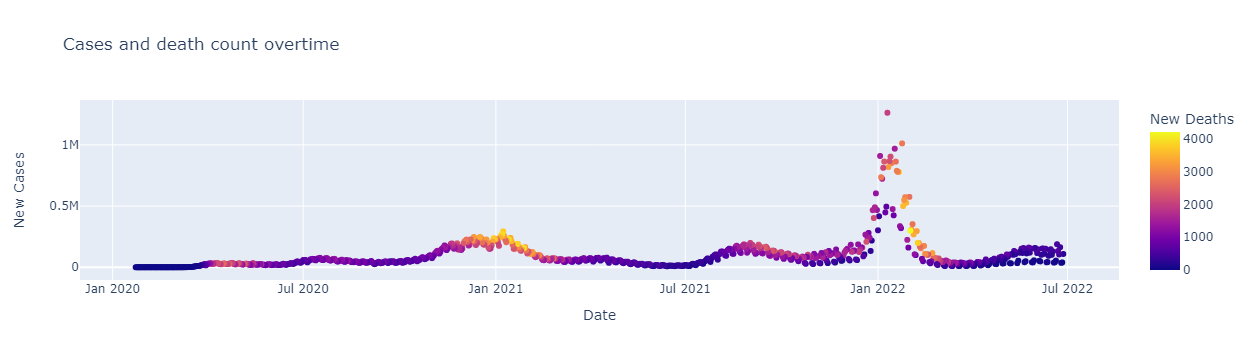

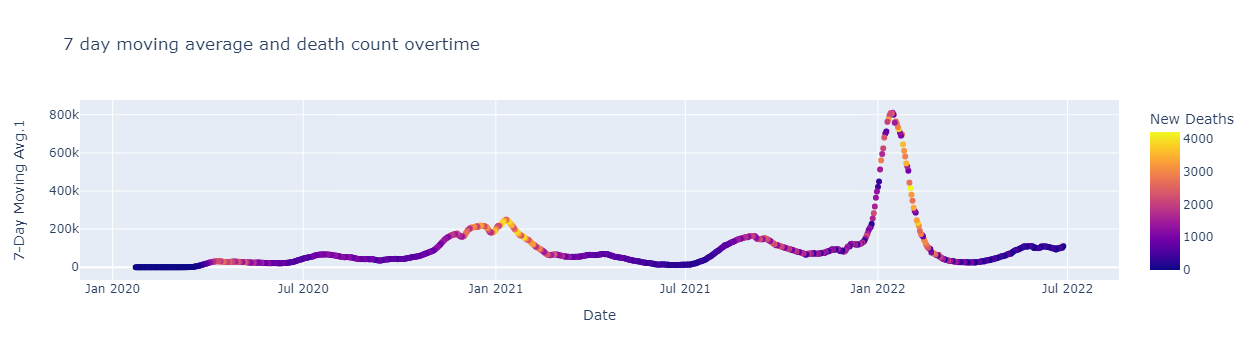

In [84]:
#PLOTTING New cases and New deaths overtime for visual refernce of distribution in a timeseries and setting pixelation dimensionality to 12 length units by 6 width units#####
fig = px.scatter(path, x="Date", y="New Cases", color='New Deaths', title="Cases and death count overtime")
(figsize:=(12,6))
fig.show()

fig = px.scatter(path, x="Date", y="7-Day Moving Avg.1", color='New Deaths', title="7 day moving average and death count overtime")
(figsize:=(12,6))
fig.show()

In [69]:
###Using numpy functions to calculate rolling mean and rolling standard deviation with a window of 21 hours then print#####
rolmean = indexedDataset.rolling(window=21).mean()
rolstd = indexedDataset.rolling(window=21).std()
print(rolmean,rolstd)

            New Deaths  7-Day Moving Avg  Historic Deaths  New Cases  \
Date                                                                   
2022-06-27         NaN               NaN              NaN        NaN   
2022-06-26         NaN               NaN              NaN        NaN   
2022-06-25         NaN               NaN              NaN        NaN   
2022-06-24         NaN               NaN              NaN        NaN   
2022-06-23         NaN               NaN              NaN        NaN   
...                ...               ...              ...        ...   
2020-01-27         0.0               0.0              0.0   0.761905   
2020-01-26         0.0               0.0              0.0   0.809524   
2020-01-25         0.0               0.0              0.0   0.809524   
2020-01-24         0.0               0.0              0.0   0.809524   
2020-01-23         0.0               0.0              0.0   0.857143   

            7-Day Moving Avg.1  Historic Cases  
Date          

In [85]:
##First ADF statistical code format using New Deaths (our variable we want to predict)####

def ad_test(path):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adfuller(path['New Deaths'])

(-3.612959645777842,
 0.005518046199839041,
 21,
 865,
 {'1%': -3.4379324415517494,
  '5%': -2.864887107873992,
  '10%': -2.568552251328143},
 11805.036271246181)

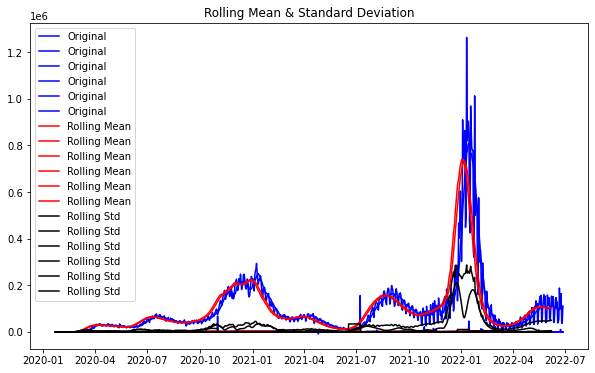

In [86]:
###Plotting mean and standard deviation of indexed dataset###
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [87]:
###Second Augmented Dickie format to check validity of first result####
##TEST STATISTIC IS EQUIVALENT TO FIRST TEST###
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['New Deaths'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -3.612960
p-value                          0.005518
#Lags Used                      21.000000
Number of Observations Used    865.000000
Critical Value (1%)             -3.437932
Critical Value (5%)             -2.864887
Critical Value (10%)            -2.568552
dtype: float64


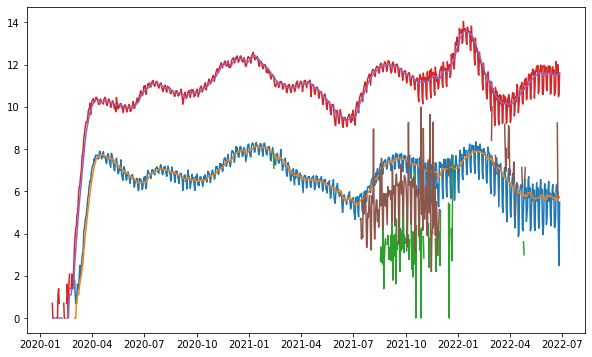

In [88]:
###LOGARITHMICALLY SCALING THE DATASET TO CHECK FOR STATIONARITY#####

indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

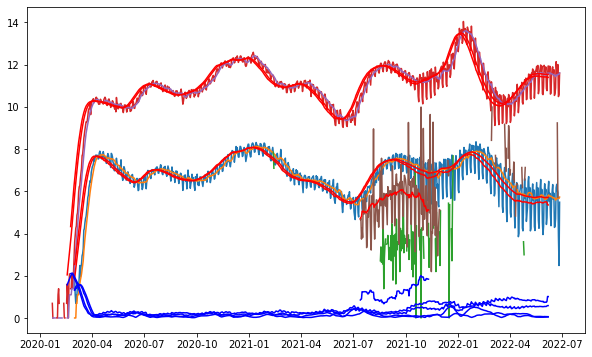

In [89]:
####DEVELOPING A STATIONARITY SERIES IN LOGARITHMIC FORM###

movingAverage = indexedDataset_logScale.rolling(window=21).mean()
movingSTD = indexedDataset_logScale.rolling(window=21).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')
plt.plot(movingSTD, color='blue')

In [90]:
###STEPWISE FITTING THE ARIMA MODEL FOR New Deaths ###

from pmdarima import auto_arima
stepwise_fit = auto_arima(path['New Deaths'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12830.103, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13365.496, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13367.276, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13366.719, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13363.497, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13094.030, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13044.897, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12758.204, Time=1.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12983.568, Time=0.82 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12753.198, Time=1.22 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=12499.157, Time=1.31 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12537.774, Time=0.99 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=12388.697, Time=1.53 sec
 ARIMA(5,1,2)(0,0,0)[0] i

In [91]:
##DEFINING THE TRAIN AND TEST FEATURES OF ARIMA TO 21 HOURS WINDOW DURATION
print(path.shape)
train=path.iloc[:-21]
test=path.iloc[-21:]
print(train.shape,test.shape)

(887, 7)
(866, 7) (21, 7)


In [92]:
####MODEL SUMMARY OF COVID ARIMA MODEL###
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['New Deaths'], order = (1,0,5))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             New Deaths   No. Observations:                  866
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -6301.785
Date:                Tue, 28 Jun 2022   AIC                          12619.571
Time:                        15:51:19   BIC                          12657.682
Sample:                             0   HQIC                         12634.156
                                - 866                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1148.2429    408.442      2.811      0.005     347.711    1948.775
ar.L1          0.9849      0.006    152.756      0.000       0.972       0.998
ma.L1         -0.3043      0.023    -13.487      0.000      -0.349      -0.260
ma.L2         -0.6937      0.021    -33.280      0.000      -0.735      -0.653
ma.L3         -0.3252      0.028    -11.709      0.000      -0.380      -0.271
ma.L4          0.4292      0.024     18.032      0.000       0.383       0.476
ma.L5          0.3036      0.027     11.153      0.000       0.250       0.357
sigma2      1.295e+05   4792.586     27.021      0.000     1.2e+05    1.39e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):               243.72
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

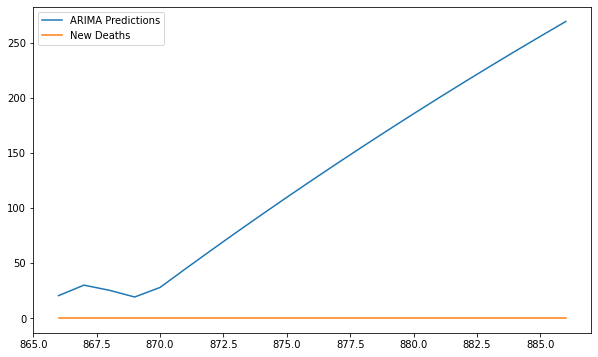

In [93]:
###Plotting ARIMA prediction###
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['New Deaths'].plot(legend=True)

In [94]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['New Deaths'].mean()
rmse=sqrt(mean_squared_error(pred,test['New Deaths']))
print(rmse)

153.33149097578567
